# World attributes 

In this tutorial, we learn how to use world attributes to write a behavior modulation.
Note that we could have used Python variables direcly, e.g.

```python
world.side_length = 1.0
```

instead of

```python
world.set("side_length", 1.0)
```

with the same effect. Yet, using attribute allow us to 

1. save/restore them from YAML
2. read/write them from C++.

This way, we could move some the classes (e.g., the modulation, the state estimation and/or the scenario) to C++.

In this scenario, a robot moves on a checkboard. The parameters of the checkboard cells (size, number, and color) are exposed as properties.
When initializing a world, the scenario write the same parameter (which may be sampled from some distribution) as attribute of the world.

In [1]:
from navground import sim, core

class MyScenario(sim.Scenario, name="Checkboard"):

    def __init__(self, number_of_cells: int = 8, side_length: float = 1.0, 
                 color_1: tuple[float, float, float] = (0.25, 0.25, 0.25), 
                 color_2: tuple[float, float, float] = (0.75, 0.75, 0.75)):
        super().__init__()
        self._side_length = side_length
        self._number_of_cells = number_of_cells
        self._color_1 = color_1
        self._color_2 = color_2

    @property
    @sim.register(1.0, "Side length")
    def side_length(self) -> float:
        return self._side_length

    @side_length.setter
    def side_length(self, value: float) -> None:
        if value <= 0:
            raise ValueError("Side length must be stricly positive")
        self._side_length = value

    @property
    @sim.register(8, "# of cells")
    def number_of_cells(self) -> int:
        return self._number_of_cells

    @number_of_cells.setter
    def number_of_cells(self, value: int) -> None:
        self._number_of_cells = max(1, value)
    
    @property
    @sim.register([0, 0, 0], "First color")
    def color_1(self) -> list[float]:
        return self._color_1

    @color_1.setter
    def color_1(self, value: list[float]) -> None:
        if len(value) == 3:
            self._color_1 = value

    @property
    @sim.register([0, 0, 0], "First color")
    def color_2(self) -> list[float]:
        return self._color_2

    @color_2.setter
    def color_2(self, value: list[float]) -> None:
        if len(value) == 3:
            self._color_2 = value
    
    def init_world(self, world: sim.World, seed: int | None = None) -> None:
        super().init_world(world, seed=seed)
        world.bounding_box = sim.BoundingBox(0, self.side_length * self.number_of_cells, 
                                             0, self.side_length * self.number_of_cells)
        

We read the world attributes to render the checkboard

In [2]:
from navground.sim.notebook import display_in_notebook    
from navground.sim.ui.to_svg import svg_color  

def checkboard(world: sim.World) -> str:
    if not (world.has("side_length") and world.has("side_length") and world.has("side_length")):
        return ''
    s = ''
    l = world.get("side_length")
    n = world.get("number_of_cells")
    color_1 = svg_color(*world.get("color_1"))
    color_2 = svg_color(*world.get("color_2"))
    for i in range(n):
        for j in range(n):
            color = color_1 if (i + j) % 2 else color_2
            s += f'<rect x="{i * l}" y="{j * l}" width="{l}" height="{l}" fill="{color}" />'
    return s

   

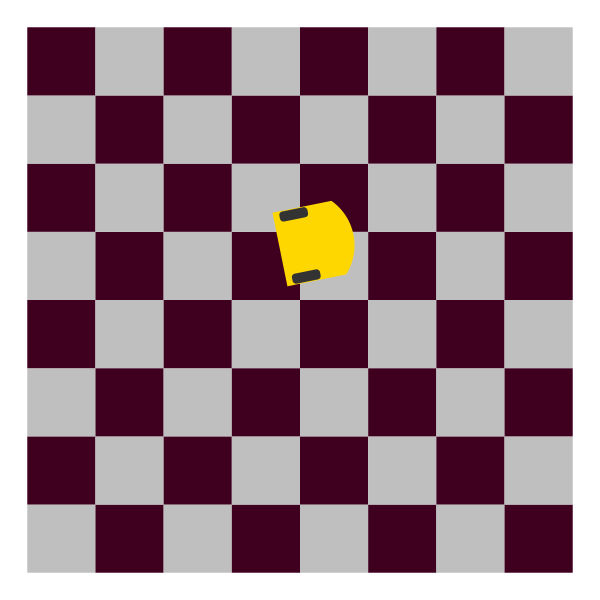

In [3]:
scenario = MyScenario(side_length=0.125, color_1=(0.25, 0.0, 0.125))
world = scenario.make_world(seed=0)
# This copies all scenario properties as world attributes
scenario.set_attributes(world)
# We could have done it manually using
# for k in scenario.properties:
#     world.set(k, scenario.get(k))
robot = sim.Agent()
robot.type = 'thymio'
robot.radius = 0.1
robot.color = 'gold'
robot.pose = core.Pose2((0.5, 0.6), 0.2)
world.add_agent(robot)
display_in_notebook(world, background_extras=[checkboard])

Attributes are also included in the YAML representation

In [4]:
yaml = world.dump()
print(yaml)

obstacles:
  []
walls:
  []
agents:
  - position:
      - 0.5
      - 0.600000024
    orientation: 0.200000003
    velocity:
      - 0
      - 0
    angular_speed: 0
    radius: 0.100000001
    control_period: 0
    speed_tolerance: 0.00999999978
    angular_speed_tolerance: 0.00999999978
    type: thymio
    color: gold
    id: 0
    uid: 0
bounding_box:
  min_x: 0
  min_y: 0
  max_x: 1
  max_y: 1
attributes:
  color_1:
    value:
      - 0.25
      - 0
      - 0.125
    type: "[float]"
  color_2:
    value:
      - 0.75
      - 0.75
      - 0.75
    type: "[float]"
  number_of_cells:
    value: 8
    type: int
  side_length:
    value: 0.125
    type: float


and therefore loaded/copied:

In [5]:
import copy

print(f'Original world attributes:\n{world.attributes}\n')

world1 = copy.copy(world)
print(f'Copied world attributes:\n{world1.attributes}\n')

world2 = sim.World.load(yaml)
print(f'Loaded world attributes:\n{world2.attributes}\n')

Original world attributes:
{'color_1': [0.25, 0.0, 0.125], 'color_2': [0.75, 0.75, 0.75], 'number_of_cells': 8, 'side_length': 0.125}

Copied world attributes:
{'color_1': [0.25, 0.0, 0.125], 'color_2': [0.75, 0.75, 0.75], 'number_of_cells': 8, 'side_length': 0.125}

Loaded world attributes:
{'color_1': [0.25, 0.0, 0.125], 'color_2': [0.75, 0.75, 0.75], 'number_of_cells': 8, 'side_length': 0.125}



We use the same world attributes to define a sensor that reads the color below the robot

In [6]:
import math 

def checkboard_color_at(position, number_of_cells, side_length, color_1, color_2):
    if position[0] > number_of_cells * side_length or position[0] < 0:
        return (0, 0, 0)
    if position[1] > number_of_cells * side_length or position[1] < 0:
        return (0, 0, 0)  
    i = math.floor(position[0] / side_length)
    j = math.floor(position[1] / side_length)
    if (i + j) % 2:
        return color_1
    return color_2

class FloorSensor(sim.Sensor, name="FloorColor"):
    
    def update(self, agent: sim.Agent, world: sim.World,
               state: core.EnvironmentState) -> None:
        if not isinstance(state, core.SensingState):
            return
        color = checkboard_color_at(agent.position, world.get("number_of_cells"), world.get("side_length"), 
                                    world.get("color_1"), world.get("color_2"))
        state.get_buffer(f'{self.name}/color').data = np.asarray(color)
        
    def get_description(self) -> dict[str, core.BufferDescription]:
        desc = core.BufferDescription([3], float, 0.0, 1.0)
        return {f'{self.name}/color': desc}

To test the whole, we define a modulation that slows down the robot when on a dark spot. 

In [7]:
import numpy as np

class SlowDownOnBlackModulation(core.BehaviorModulation, name="SlowDownOnDark"):

    def pre(self, behavior: core.Behavior, time_step: float):
        color = behavior.environment_state.buffers['/color'].data
        intensity = np.mean(color)
        self._optimal_speed = behavior.optimal_speed
        behavior.optimal_speed = intensity * behavior.optimal_speed

    def post(self, behavior: core.Behavior, time_step: float, cmd: core.Twist2) -> core.Twist2:
        behavior.optimal_speed = self._optimal_speed
        return cmd

Let us run it once

In [8]:
scenario = sim.load_scenario("""
type: Checkboard
side_length:
  sampler: uniform
  from: 0.25
  to: 1.0
number_of_cells: 10
number: 100
color: [0.2, 0.4, 0.3]
color: [0.6, 0.7, 0.8]
groups:
  - number: 1
    type: thymio
    color: gold
    radius: 0.1
    position: [1.13, 0.71]
    kinematics:
      type: 2WDiff
      max_speed: 0.14
      wheel_axis: 0.09
    behavior:
      type: Dummy
      environment: Sensing
      modulations:
        - type: SlowDownOnDark
    state_estimation:
      type: FloorColor
      name: floor
    task:
      type: Waypoints
      waypoints: [[0.75, 1.5], [5.3, 2.2], [1.5, 4.9]]
      tolerance: 0.02
""")

In [9]:
from navground.sim.ui.video import display_video

world = scenario.make_world()
scenario.set_attributes(world)
display_video(world, time_step=0.1, duration=120, factor=20, 
              background_extras=[checkboard]
              )

Finally, we perform some experiments, sampling the cell size uniformly.

In [10]:
experiment = sim.Experiment(time_step=0.1, steps=100)
experiment.scenario = scenario
experiment.record_config.efficacy = True
experiment.run(number_of_runs=1000)

The sampled checkboard configuration are included in the initial state of the world saved by the experiment, and also accessible through the API.

In [11]:
experiment.runs[50].world.attributes

{'color_1': [0.25, 0.25, 0.25],
 'color_2': [0.75, 0.75, 0.75],
 'number_of_cells': 10,
 'side_length': 0.620951235294342}

which we can use to compute the (not very interesting) correlation between cell size and mean efficacy

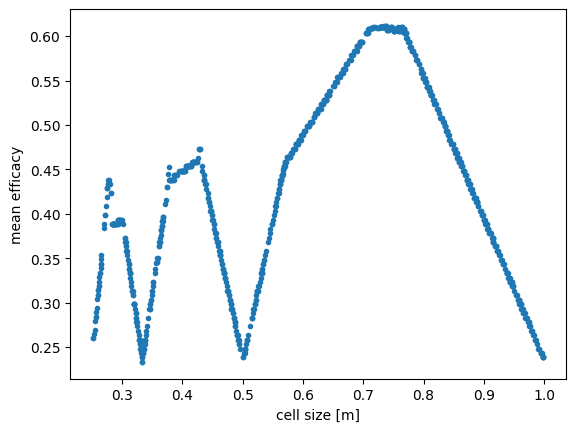

In [12]:
from matplotlib import pyplot as plt

sizes = [run.world.get('side_length') for run in experiment.runs.values()]
efficacy = [np.mean(run.efficacy) for run in experiment.runs.values()]
plt.plot(sizes, efficacy, '.')
plt.xlabel('cell size [m]')
plt.ylabel('mean efficacy');